# Predicting Home Sale Price

This will attempt to be similar to the Zestimate used on Zillow, the Redfin estimate used on Redfin, or any of the valuations provided by Collateral Analytics, CoreLogic, or Quantarium on Realtor.com.

I will create a regression model and use it to predict valuation and compare to the other valuations on currently listed homes.

In [2]:
%run src/imports.py
from src.helpers import calculate_five_percent, calculate_ten_percent, calculate_twenty_percent

In [3]:
sns.set(rc={'figure.figsize':(16,4)})

In [6]:
modeldata = pd.read_pickle('data/modeldata.pkl')

In [7]:
modeldata

,ZIP OR POSTAL CODE,PRICE,SQUARE FEET,LOT SIZE,YEAR BUILT,HOA/MONTH,LATITUDE,LONGITUDE,ROOMS,MONTH,YEAR
0,78257,345000,1989.0,5662.0,2005.0,230.0,29.647801,-98.614186,4.0,9,2020
1,78256,337500,2166.0,9583.0,2004.0,54.0,29.650304,-98.629082,6.0,6,2020
2,78256,375500,2969.0,6605.0,2004.0,54.0,29.651842,-98.630650,6.5,3,2021
3,78255,462000,2716.0,9147.0,2014.0,95.0,29.617650,-98.643430,7.0,10,2018
4,78256,624000,3012.0,75794.0,2000.0,25.0,29.620646,-98.622295,5.5,2,2021
...,...,...,...,...,...,...,...,...,...,...,...
20007,78222,153000,1577.0,6969.0,1983.0,0.0,29.383410,-98.376520,5.0,9,2019
20008,78222,189900,1703.0,4791.0,2018.0,25.0,29.386700,-98.379900,6.0,7,2018
20009,78222,128000,1102.0,5662.0,1985.0,0.0,29.383092,-98.376562,5.0,3,2019
20010,78222,196499,2324.0,5662.0,2014.0,6.0,29.379346,-98.370269,7.0,3,2019


-----
Data Density  
= 11,654 / 11  
= 1059
-----
With smaller dataset  
= 1,000 / 11  
= 91
----

## Building a Model

Smaller set:

In [8]:
df_small = modeldata.sample(1000)
y = df_small['PRICE'].values
X = df_small.drop('PRICE',axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [25]:
y = modeldata['PRICE'].values
X = modeldata.drop('PRICE',axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [26]:
rfr = RandomForestRegressor(oob_score=True)
rfr.fit(X_train,y_train)
y_predict = rfr.predict(X_test)
print("score:", rfr.score(X_test, y_test))
print('MSE: {:2e}'.format(mean_squared_error(y_test, y_predict)))
print(calculate_five_percent(y_predict,y_test))
print(calculate_ten_percent(y_predict,y_test))
print(calculate_twenty_percent(y_predict,y_test))

score: 0.8002040558389889
MSE: 5.667402e+09
49.00060569351908
71.1084191399152
88.26973551383


In [10]:
search_space = [{'regressor__alpha': 10 ** (np.linspace(-5, 5, 10)), 
                 'regressor__l1_ratio': np.linspace(0,1,6)}]

# l_lasso / (l_lasso + l_ridge)
# if l_lasso = 0: 0 / 1 = 0 (this is ridge regression)
# if l_ridge = 0: l_lasso / l_lasso = 1 (this is LASSSO regression)

pipe = Pipeline([('scaler', StandardScaler()), ('regressor', ElasticNet())])

enet_cv = GridSearchCV(pipe, 
                      search_space, 
                      cv=KFold(10, shuffle=True), 
                      scoring='neg_mean_squared_error',
                      return_train_score = True)
enet_cv.fit(X_train,y_train)

print(enet_cv.best_params_)

y_predict = enet_cv.predict(X_test)
print('MSE: {:2e}'.format(mean_squared_error(y_test, y_predict)))
print(calculate_five_percent(y_predict,y_test))
print(calculate_ten_percent(y_predict,y_test))
print(calculate_twenty_percent(y_predict,y_test))

/Users/randallbloomquist/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2790398349155.116, tolerance: 1311002112.6500173
  model = cd_fast.enet_coordinate_descent(
/Users/randallbloomquist/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3077268448852.238, tolerance: 1565508902.4464314
  model = cd_fast.enet_coordinate_descent(
/Users/randallbloomquist/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2885331866344.253, tolerance: 1456204779.596652
  model = cd_fast.enet_coordinate_descent(
/Users/randallbloomquist/opt/anacon

{'regressor__alpha': 46.41588833612782, 'regressor__l1_ratio': 0.8}
MSE: 1.976368e+10
10.0
18.8
37.6


/Users/randallbloomquist/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7527219272540.936, tolerance: 1505459135.7030735
  model = cd_fast.enet_coordinate_descent(


In [27]:
ridge = Ridge(alpha=1)
ridge.fit(X_train,y_train)
y_predict = ridge.predict(X_test)
print("score:", ridge.score(X_test, y_test))
print('MSE: {:2e}'.format(mean_squared_error(y_test, y_predict)))
print(calculate_five_percent(y_predict,y_test))
print(calculate_ten_percent(y_predict,y_test))
print(calculate_twenty_percent(y_predict,y_test))

score: 0.5362856621849305
MSE: 1.315370e+10
11.710074702200686
23.88451443569554
49.16212396527357


In [28]:
lr = LinearRegression()
lr.fit(X_train,y_train)
y_predict = lr.predict(X_test)
print("score:", lr.score(X_test, y_test))
print('MSE: {:2e}'.format(mean_squared_error(y_test, y_predict)))
print(calculate_five_percent(y_predict,y_test))
print(calculate_ten_percent(y_predict,y_test))
print(calculate_twenty_percent(y_predict,y_test))

score: 0.5362814077045177
MSE: 1.315382e+10
11.710074702200686
23.90470421966485
49.16212396527357


In [29]:
kf = KFold()
skf = StratifiedKFold()
ridge_pipe = Pipeline([('scaler', StandardScaler()), ('regressor', Ridge())])
ridge_grid_params = {'regressor__alpha': np.arange(0,50,1)}
ridge_grid = GridSearchCV(ridge_pipe, ridge_grid_params, cv=kf, scoring = 'neg_mean_squared_error')
ridge_grid.fit(X_train, y_train)
y_predict = ridge_grid.predict(X_test)
print("Ridge Accuracy: {:.2e}".format(ridge_grid.score(X_test, y_test)))
print(calculate_five_percent(y_predict,y_test))
print(calculate_ten_percent(y_predict,y_test))
print(calculate_twenty_percent(y_predict,y_test))

Ridge Accuracy: -1.32e+10
11.710074702200686
23.90470421966485
49.16212396527357


In [30]:
kf = KFold()
skf = StratifiedKFold()
lasso_pipe = Pipeline([('scaler', StandardScaler()), ('regressor', Lasso())])
lasso_grid_params = {'regressor__alpha': np.arange(0.1,0.9,0.1)}
lasso_grid = GridSearchCV(lasso_pipe, lasso_grid_params, cv=kf, scoring = 'neg_mean_squared_error')
lasso_grid.fit(X_train, y_train)
y_predict = lasso_grid.predict(X_test)
print("Lasso Accuracy: {:.2e}".format(lasso_grid.score(X_test, y_test)))
print(calculate_five_percent(y_predict,y_test))
print(calculate_ten_percent(y_predict,y_test))
print(calculate_twenty_percent(y_predict,y_test))

Lasso Accuracy: -1.32e+10
11.710074702200686
23.90470421966485
49.16212396527357


In [31]:
kf = KFold()
skf = StratifiedKFold()
gbr_pipe = Pipeline([('scaler', StandardScaler()), ('regressor', GradientBoostingRegressor(loss='huber'))])
gbr_grid_params = {'regressor__alpha': np.arange(0.1,0.9,0.2),
                  'regressor__max_depth': np.arange(1,9,2),
                  'regressor__learning_rate': np.arange(0.01,0.2,0.03)}
gbr_grid = GridSearchCV(gbr_pipe, gbr_grid_params, cv=kf, scoring = 'neg_mean_squared_error')
gbr_grid.fit(X_train, y_train)
y_predict = gbr_grid.predict(X_test)
print("gbr Accuracy: {:.2e}".format(gbr_grid.score(X_test, y_test)))
print(calculate_five_percent(y_predict,y_test))
print(calculate_ten_percent(y_predict,y_test))
print(calculate_twenty_percent(y_predict,y_test))

gbr Accuracy: -6.67e+09
46.17403593781547
69.3519079345851
86.71512214819302


In [35]:
gbr_grid.best_params_

{'regressor__alpha': 0.7000000000000001,
 'regressor__learning_rate': 0.13,
 'regressor__max_depth': 5}

In [32]:
kf = KFold()
skf = StratifiedKFold()
rfr_pipe = Pipeline([('scaler', StandardScaler()), ('regressor', RandomForestRegressor())])
rfr_grid_params = {'regressor__n_estimators': np.arange(50,250,10),
                  'regressor__max_depth': np.arange(1,15,2)}
rfr_grid = GridSearchCV(rfr_pipe, rfr_grid_params, cv=kf, scoring = 'neg_mean_squared_error')
rfr_grid.fit(X_train, y_train)
y_predict = rfr_grid.predict(X_test)
print("rfrAccuracy: {:.2e}".format(rfr_grid.score(X_test, y_test)))
print(calculate_five_percent(y_predict,y_test))
print(calculate_ten_percent(y_predict,y_test))
print(calculate_twenty_percent(y_predict,y_test))

rfrAccuracy: -5.76e+09
42.13607914395316
67.47425802543913
86.93720977185544


In [56]:
kf = KFold()
skf = StratifiedKFold()
gbr_pipe2 = Pipeline([('scaler', StandardScaler()), ('regressor', GradientBoostingRegressor(loss='huber'))])
gbr_grid_params2 = {'regressor__alpha': np.arange(0.1,0.9,0.3)}
gbr_grid2 = GridSearchCV(gbr_pipe2, gbr_grid_params2, cv=kf, scoring = 'neg_mean_squared_error')
gbr_grid2.fit(X_train, y_train)
y_predict = gbr_grid2.predict(X_test)
print("gbr Accuracy: {:.2e}".format(gbr_grid.score(X_test, y_test)))
print(calculate_five_percent(y_predict,y_test))
print(calculate_ten_percent(y_predict,y_test))
print(calculate_twenty_percent(y_predict,y_test))

gbr Accuracy: -6.87e+09
30.8
54.800000000000004
79.2


In [38]:
gbr_grid2.best_params_

{'regressor__alpha': 0.7000000000000001}

In [39]:
X_df = pd.DataFrame(X)

In [40]:
X_df.corr() > 0.2

,0,1,2,3,4,5,6,7,8,9
0,True,False,False,False,False,True,False,False,False,False
1,False,True,False,True,True,True,False,True,False,False
2,False,False,True,False,False,False,False,False,False,False
3,False,True,False,True,True,True,False,True,False,False
4,False,True,False,True,True,True,False,True,False,False
5,True,True,False,True,True,True,False,True,False,False
6,False,False,False,False,False,False,True,False,False,False
7,False,True,False,True,True,True,False,True,False,False
8,False,False,False,False,False,False,False,False,True,False
9,False,False,False,False,False,False,False,False,False,True


In [41]:
X_train = sm.add_constant(X_train)

In [42]:
X_opt = X_train[:,np.arange(0,10)]
regressor_OLS = sm.OLS(endog = y_train, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.560
Model:                            OLS   Adj. R-squared:                  0.555
Method:                 Least Squares   F-statistic:                     104.8
Date:                Sat, 27 Mar 2021   Prob (F-statistic):          1.09e-125
Time:                        18:53:22   Log-Likelihood:                -9780.8
No. Observations:                 750   AIC:                         1.958e+04
Df Residuals:                     740   BIC:                         1.963e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.91e+07   7.25e+06      2.636      0.009    4.88e+06    3.33e+07
x1          -257.0925     97.375     -2.640      0.008    -448.258     -65.928
x2           167.3773      9.990     16.755      0.000     147.766     186.989
x3             0.4295      0.131      3.285      0.001       0.173       0.686
x4         -1767.9014    158.376    -11.163      0.000   -2078.821   -1456.982
x5           426.3365    173.307      2.460      0.014      86.104     766.569
x6            4.7e+04   5.06e+04      0.929      0.353   -5.23e+04    1.46e+05
x7         -3.107e+04   3.28e+04     -0.949      0.343   -9.54e+04    3.32e+04
x8         -1965.1738   5510.107     -0.357      0.721   -1.28e+04    8852.131
x9          -721.3523   1249.411     -0.577      0.564   -3174.166    1731.461
==============================================================================
Omnibus:                      771.327   Durbin-Watson:                   1.832
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            75725.392
Skew:                           4.492   Prob(JB):                         0.00
Kurtosis:                      51.399   Cond. No.                     1.39e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.39e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [43]:
X_opt = X_train[:,[0,1,2,4,5,6,7,8,9,10]]

In [44]:
regressor_OLS = sm.OLS(endog = y_train, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.550
Method:                 Least Squares   F-statistic:                     102.9
Date:                Sat, 27 Mar 2021   Prob (F-statistic):          4.08e-124
Time:                        18:53:22   Log-Likelihood:                -9784.5
No. Observations:                 750   AIC:                         1.959e+04
Df Residuals:                     740   BIC:                         1.964e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.449e+06   1.22e+07      0.363      0.716   -1.96e+07    2.85e+07
x1          -264.8363     97.830     -2.707      0.007    -456.894     -72.778
x2           170.8658      9.960     17.156      0.000     151.313     190.418
x3         -1751.2316    159.717    -10.965      0.000   -2064.784   -1437.680
x4           466.5946    174.440      2.675      0.008     124.138     809.051
x5          5813.4052   4.99e+04      0.116      0.907   -9.22e+04    1.04e+05
x6         -1.517e+04   3.26e+04     -0.466      0.642   -7.92e+04    4.88e+04
x7         -1961.3432   5541.075     -0.354      0.723   -1.28e+04    8916.757
x8           -12.4337   1313.039     -0.009      0.992   -2590.160    2565.292
x9          8911.6173   4811.572      1.852      0.064    -534.339    1.84e+04
==============================================================================
Omnibus:                      760.353   Durbin-Watson:                   1.814
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            72443.149
Skew:                           4.391   Prob(JB):                         0.00
Kurtosis:                      50.340   Cond. No.                     2.33e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.33e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [45]:
sns_plot = sns.histplot(data=df['MONTH'],kde=True,shrink=2,binrange=[1,13],binwidth=.5).set_title('Houses Sold By Month')
fig = sns_plot.get_figure()
fig.savefig('img/housesbymonth.png')y_predict = regressor_OLS.predict(X_test)

In [46]:
print('MSE: {:.2e}'.format(mean_squared_error(y_test, y_predict)))

MSE: 1.21e+23


In [47]:
calculate_five_percent(y_predict,y_test)
calculate_ten_percent(y_predict,y_test)
print(calculate_twenty_percent(y_predict,y_test))

0.0


## Feature Importances

In [33]:
rfr_grid.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('regressor',
                 RandomForestRegressor(max_depth=13, n_estimators=120))])

In [34]:
rfr_grid.best_estimator_.steps[1][1]

RandomForestRegressor(max_depth=13, n_estimators=120)

In [35]:
std = np.std([tree.feature_importances_ for tree in rfr_grid.best_estimator_.steps[1][1].estimators_],axis=0)
std

array([0.01228483, 0.01883107, 0.00835079, 0.01407618, 0.02981249,
       0.01205757, 0.01754874, 0.00599366, 0.0031491 , 0.00503621])

In [36]:
feature_importances = rfr_grid.best_estimator_.steps[1][1].feature_importances_

In [37]:
feature_importances

array([0.04309778, 0.59934286, 0.05608799, 0.07904959, 0.07795421,
       0.06254325, 0.05392468, 0.01256994, 0.00746612, 0.00796357])

In [38]:
features = np.array(modeldata.drop('PRICE',axis=1).columns)

In [39]:
importances_df = pd.DataFrame([feature_importances],columns=features)
importances_df

,ZIP OR POSTAL CODE,SQUARE FEET,LOT SIZE,YEAR BUILT,HOA/MONTH,LATITUDE,LONGITUDE,ROOMS,MONTH,YEAR
0,0.043098,0.599343,0.056088,0.07905,0.077954,0.062543,0.053925,0.01257,0.007466,0.007964


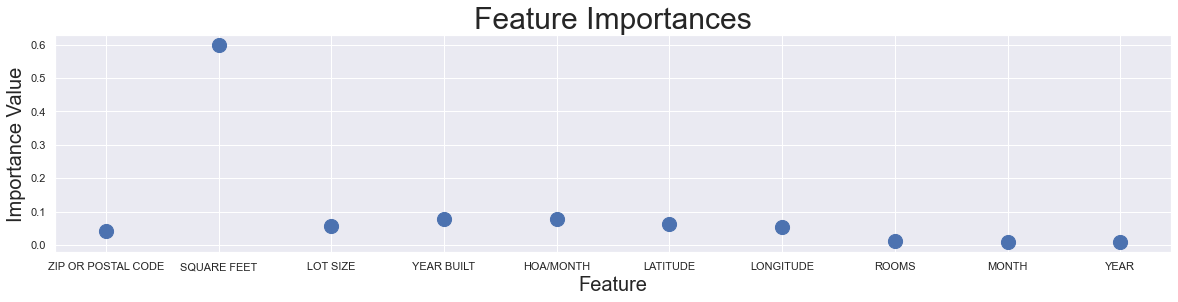

In [40]:
plt.figure(figsize=(20,4))
plt.scatter(x=features,y=feature_importances,s=200)
plt.title('Feature Importances',fontsize=30)
plt.ylabel('Importance Value',fontsize=20)
plt.xlabel("Feature",fontsize=20)
plt.savefig('img/featureimportances2.png')